# Importing packages

Importing necessary packages to perform calculations and creating plots.

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="FixedFormatter should only be used together")

# Script 1: Reading answers from google sheet

This script is used for converting raw data (file <span style="color:orange">'data/Survey_raw.csv'</span>) obtained from Google Forms in form of .csv Google Sheet table into more interpretable format of answer database. First, it ensures that answers were taken from 01.11.2022 to 31.05.2023 and manually fixes bugs like <span style="color:orange">Targetmol</span> instead of <span style="color:orange">Target**M**ol</span> and removing data from <span style="color:orange">'413_'</span>. <span style="color:orange">'413_'</span> row is an additional data of participant <span style="color:orange">'413'</span> that filled databases like Reaxys and Scifinder a bit later. Missing data was transferred manually from <span style="color:orange">'413_'</span> into <span style="color:orange">'413'</span>. <br> <br>
Then this script reads each column in <span style="color:orange">'data/Survey_raw.csv'</span> which indicates question, database, whether it was compound or target and its serial number. All this information is taken to create such columns as Id, section, instance_type, participant, database, answer. Finally, database_type is assigned manually. The result is saved like <span style="color:orange">'data/Survey_answers.csv'</span>


In [213]:
# Read raw Excel sheet
rawData = pd.read_csv('data/Survey_raw.csv', delimiter=';')
rawData['Timestamp'] = pd.to_datetime(rawData['Timestamp'], format='%d.%m.%Y %H:%M:%S')
rawData = rawData[(rawData['Timestamp'] > pd.to_datetime('01.11.2022', format='%d.%m.%Y')) 
                    & (rawData['Timestamp'] < pd.to_datetime('31.05.2023', format='%d.%m.%Y'))]

# additional data about SciFinder were paste manually from 413_ to 413 row
rawData = rawData[rawData['Please enter your data barcode'] != '413_']

# Fix TargetMol Name
rawData.rename(columns=
        {'What did you like the on each site? [Targetmol]':'What did you like the on each site? [TargetMol]',
        'What did you NOT like the on each site? [Targetmol]': 'What did you NOT like the on each site? [TargetMol]',}, 
        inplace=True)


database_classification={'ChEMBL':'Academia','Guide to Pharmacology':'Academia','Probes and Drugs':'Academia',
                        'DrugBank':'Academia','TargetMol':'Vendor','MedChemExpress':'Vendor',
                        'SelleckChem':'Vendor','Toronto Research Chemicals':'Vendor',
                        'Tocris':'Vendor','Cayman':'Vendor','Santa Cruz':'Vendor',
                        'Reaxys':'Closed','SciFinder':'Closed'}


participants = [p for p in rawData['Please enter your data barcode'].to_list()]
compounds = ['[Compound 1]','[Compound 2]','[Compound 3]','[Compound 4]','[Compound 5]']
targets = ['[Target 1]', '[Target 2]', '[Target 3]'] 


def getSection(col, p):
    

    # Section
    col_brackets = re.findall('\[.+\]',col)[0].strip('[]').split(' ')[0] # extract whether it is compound or target
    if ('Compound' == col_brackets) and ('.' not in col):
        section = 'CPD_search'
    elif ('Compound' == col_brackets) and ('.' in col):
        section = 'CPD_biodata'
    elif ('Target' == col_brackets) and ('.' not in col):  
        section = 'TAR_search'
    elif ('Target' == col_brackets) and ('.' in col):
        section = 'TAR_biodata'
    else:
        section = 'Assessment'

    if section != 'Assessment':
        number = re.findall('\[.*?\]',col)[0][-2]  
        Id = f'{section[0]}{p}{number}'
        
    else:
        Id = f'A{p}'

    return section, Id


# Unpack Google Sheet data and create dataframe
dfs = []
df_assessment = []
for p in participants:
    partData = rawData[rawData['Please enter your data barcode'] == p]
    for db in database_classification:
        db_cols = [colName for colName in rawData.columns if (db in colName) and ('[' in colName)]
        for col in db_cols:
            section, Id = getSection(col,p)
            if 'What did you' not in col: # Not Assessment
                if pd.notnull(partData[col].iloc[0]):
                    dfx = pd.DataFrame({'answer':partData[col].iloc[0].split(', ')})
                else:
                    dfx = pd.DataFrame({'answer':[np.nan]})
                dfx['Id'] = Id
                dfx['section'] = section
                dfx['database'] = db
                dfx['participant'] = p
                dfs.append(dfx)
            else: # Assessment
                df_a = pd.DataFrame({'answer':partData[col].iloc[0].split(', ')})
                df_a['instance_categoryT'] = ('NEGATIVE' if 'NOT' in col else 'POSITIVE')
                df_a['Id'] = Id
                df_a['section'] = section
                df_a['database'] = db
                df_a['participant'] = p
                df_assessment.append(df_a)
      
# Combining assessment and not assessment results
answers = pd.concat(dfs + df_assessment, axis=0, ignore_index=True)

# Adding compound/target classification inforamtion
CPD_df=pd.read_csv('data/cpd_database.csv')
TAR_df=pd.read_csv('data/TAR_database.csv')

CPD_df['Id'] = CPD_df.apply(lambda row: f'C{row.PARTICIPANT}{row.N}', axis=1) 
TAR_df['Id'] = TAR_df.apply(lambda row: f'T{row.PARTICIPANT}{row.N}', axis=1)

instance_info = pd.concat([CPD_df[['Id','category']], TAR_df[['Id','category']]], ignore_index=True)
instance_info = instance_info.rename(columns={'category':'instance_category'})
answers = answers.merge(instance_info, on='Id', how='left')

answers.loc[answers['instance_categoryT'].notnull(), 'instance_category'] = \
    answers.loc[answers['instance_categoryT'].notnull(), 'instance_categoryT']

##### Correcting Google Form table errors  (Tocris) #####
answers.loc[(answers.database == 'Tocris'), 'answer'] = \
    answers.loc[(answers.database == 'Tocris'), 'answer'].replace({'Action on target':'Target',
                                                                   'Activity type':'Action on target'})


# Adding instance type
answers['instance_type'] = answers['section'].apply(lambda sec: 'compound' if sec[:3] == 'CPD' else 'target')

# Adding database classification
answers['database_type'] = answers['database'].apply(lambda db: database_classification[db])


cols_out = ['Id', 'section', 'instance_type','instance_category', 
            'participant','database', 'answer', 'database_type']
answers = answers[cols_out]

# Save result
# answers.to_csv('/data/SURVEY_answers.csv', index=False)

answers

,Id,section,instance_type,instance_category,participant,database,answer,database_type
0,C2071,CPD_search,compound,PROBE,207,ChEMBL,Synonym 1,Academia
1,C2071,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
2,C2072,CPD_search,compound,PROBE,207,ChEMBL,Synonym 2,Academia
3,C2072,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
4,C2073,CPD_search,compound,CLINICAL_TRIALS,207,ChEMBL,Synonym 1,Academia
...,...,...,...,...,...,...,...,...
15597,A407,Assessment,target,NEGATIVE,407,Reaxys,Nothing special,Closed
15598,A407,Assessment,target,POSITIVE,407,SciFinder,Information representation*,Closed
15599,A407,Assessment,target,POSITIVE,407,SciFinder,Visually attractive interface,Closed
15600,A407,Assessment,target,POSITIVE,407,SciFinder,Search system**,Closed


# Loading saved data and additional info


Info like database names, answer types and compound/target names are written explicitly to help create plots in further steps. <br> <br>
Created answer database using Script 1 are loaded (<span style="color:orange">'data/Survey_answers.csv'</span>) and helping data tables like <span style="color:orange">'data/cpd_database.csv'</span> and <span style="color:orange">'data/TAR_database.csv'</span> that contain explicit and additional information about compounds and targets respectively tested during the survey. This information regards data like IUPAC name, classification information etc. 


In [243]:
databases=['ChEMBL','Guide to Pharmacology','Probes and Drugs','DrugBank',
                   'TargetMol','MedChemExpress','SelleckChem','Toronto Research Chemicals',
                   'Tocris','Cayman','Santa Cruz','Reaxys', 'SciFinder']
#ROWS
compounds=['[Compound 1]','[Compound 2]','[Compound 3]','[Compound 4]','[Compound 5]']
targets=['[Target 1]', '[Target 2]', '[Target 3]'] 
        
#ANSWERS SEARCH
search_compounds=['Synonym 1', 'Synonym 2', 'Synonym 3',
                               'CAS number', 'Structure search', 'Not found']
search_targets=['Synonym 1', 'Synonym 2', 'Synonym 3',
                             'UniprotID', 'Not found']
        
        
#ANSWERS BIODATA
biodata_compounds=['Other form','Target','Action on target','Substance effect',
                        'Activity coefficient','Disease','In vivo data','Assay details',
                        'Toxicology','Metabolism','References', 'Not found']
biodata_targets=['Target family page','Ligand list','Target description',
                        'Classification tree','Disease','Not found']

#ANSWERS ASSESMENT
assesment=['Information representation*','Visually attractive interface',
                'Search system**','Nothing special']
assesmentNOT=['Slow search','Information representation*',
                    'Complicated search outcome**','Nothing special']

CPD_df=pd.read_csv('data/cpd_database.csv')
TAR_df=pd.read_csv('data/TAR_database.csv')

# answer database from previous step
database = pd.read_csv('data/SURVEY_answers.csv')
database.head() 

,Id,section,instance_type,instance_category,participant,database,answer,database_type
0,C2071,CPD_search,compound,PROBE,207,ChEMBL,Synonym 1,Academia
1,C2071,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
2,C2072,CPD_search,compound,PROBE,207,ChEMBL,Synonym 2,Academia
3,C2072,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
4,C2073,CPD_search,compound,CLINICAL_TRIALS,207,ChEMBL,Synonym 1,Academia


# Plots


## Compound and target distribution

This code extract is describing process of creating plots for compound and target samples distributions. Some categories for targets were combined to make figure more readable. 

Text(0.5, 1.0, 'Targets')

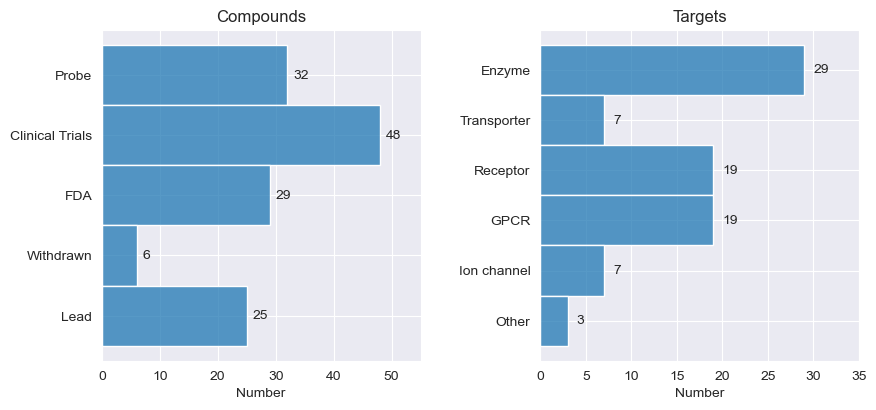

In [244]:
# compound & target category distributions
df_cpds = database[(database.section == 'CPD_search')][['Id','instance_category']].drop_duplicates('Id')
df_tars = database[(database.section == 'TAR_search')][['Id','instance_category']].drop_duplicates('Id')

# Making graph more readable
df_cpds['instance_category'] = df_cpds['instance_category'].replace({'PROBE':'Probe','CLINICAL_TRIALS':'Clinical Trials', 
                                                                     'WITHDRAWN':'Withdrawn', 'LEAD':'Lead', 
                                                                     'FDA':'FDA',})

df_tars['instance_category'] = df_tars['instance_category'].replace({'enzyme':'Enzyme', 'transporter':'Transporter',
                                                                     'Other_receptors':'Receptor', 'gpcr':'GPCR', 
                                                                      'Ionic Channel':'Ion channel', 'other_protein':'Other', 
                                                                      'other_ic':'Ion channel', 'lgic':'Ion channel', 
                                                                      'vgic':'Ion channel', 
                                                                      'nhr':'Receptor', 'catalytic_receptor':'Receptor',
                                                                      })

#plot
f, axs = plt.subplots(1,2,facecolor='none',figsize=(9,4))

sns.histplot(y=df_cpds.instance_category, ax=axs[0])
sns.histplot(y=df_tars.instance_category, ax=axs[1])




ylimit = [55, 35]
f.tight_layout()


for i in range(2):
       axs[i].set(xlim=(0,ylimit[i]), ylabel="",xlabel="Number", )

       for p in axs[i].patches:
              width = p.get_width()    # get bar length
              axs[i].text(width + 1,       # set the text at 1 unit right of the bar
                     p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                     f'{width:.0f}', # set variable to display, 2 decimals
                     ha = 'left',   # horizontal alignment
                     va = 'center')  # vertical alignment
              
axs[0].set_title('Compounds')
axs[1].set_title('Targets')


## IUPAC statistics

This code describes creation of table with typical lengths of found IUPAC strings in each database. The results are expressed as mean ± standard deviation. 

In [251]:
compounds = database[database['instance_type'] == 'compound']
syn2 = compounds[compounds['answer'] == 'Synonym 2']
map_dic={f'C{row[0]}{row[1]}': len(row[-1]) for row in CPD_df.to_numpy()}
syn2['IUPAC string len']=syn2['Id'].map(map_dic)

val, db_list, N_syn2=[],[],[]
for db in databases:
        df=syn2
        df=df[df['database']==db]['IUPAC string len']
        cnt,mean,std=df.describe().loc[['count','mean','std']].round(1)
        db_list.append(db)
        N_syn2.append(round(cnt))
        if str(mean) == 'nan' or str(std) == 'nan':
                val.append(f'-')
        else:
                val.append(f'{mean}±{std}')



pd.DataFrame({
        'Database':db_list,
        'IUPAC string len': val,
        'N of Synonym2':N_syn2,
}).sort_values(by=['N of Synonym2'], ascending=False).reset_index(drop=True)


/var/folders/fb/3w9s6w2d3s9c5km783sbypd80000gn/T/ipykernel_26367/675997684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn2['IUPAC string len']=syn2['Id'].map(map_dic)


,Database,IUPAC string len,N of Synonym2
0,Reaxys,77.6±33.5,54
1,ChEMBL,80.1±40.3,42
2,DrugBank,79.2±36.5,26
3,Santa Cruz,72.8±40.4,23
4,SelleckChem,87.0±39.1,21
5,MedChemExpress,86.4±40.4,14
6,Tocris,82.0±33.8,14
7,Guide to Pharmacology,96.5±62.9,11
8,Toronto Research Chemicals,70.0±61.8,11
9,Cayman,65.8±31.8,11


## Script 2: Plots for each section

This script was used to create figures that represent answer distributions across each database and across all at once. To access certain plot, one needs to enter desired section (<span style="color:orange">'CPD_search'</span>,<span style="color:orange">'CPD_biodata'</span>,<span style="color:orange">'TAR_search'</span> or <span style="color:orange">'TAR_biodata'</span>)

In [245]:
def plot_section(section, x_name='answer'):
    
    section_questions = {
        'CPD_search':search_compounds,
        'CPD_biodata':biodata_compounds,
        'TAR_search':search_targets,
        'TAR_biodata':biodata_targets,
        'Assesment': {
            'POSITIVE':assesment,
            'NEGATIVE':assesmentNOT
                        }
    }

    palt = {
        'Academia' : 'tab:green',
        'Vendor' : 'tab:orange',
        'Closed' : 'tab:blue',
    }

    xlims = {
        'CPD_search':(0,125),
        'CPD_biodata':(0,130),
        'TAR_search': (0,85),
        'TAR_biodata':(0,80),
        }
    # Data initialization + sorting for proper order on graphs
    plot_data = database
    sort_dictionary = {cat:ind for ind,cat in enumerate(section_questions[section])}
    plot_data = plot_data[plot_data['section']==section].sort_values(by=[x_name], axis=0, key=lambda x:x.map(sort_dictionary))
    if x_name != 'answer':
        plot_data=plot_data[plot_data['answer']=='Synonym 1']

    def sns_plot(df, db, ax):
        ax.set_title(f'{db}', fontsize=16)
        df=df[df['database']==db]
        g=sns.histplot(data=df, y=x_name, bins=16,  ax=ax, hue='database_type', palette=palt, 
                       kde=False)
        
        
        g.legend([], [], frameon=False)
        g.set_ylabel('')
        g.set_xlabel('')
        g.set_xlim(xlims[section])


        
        if 'CPD_search' == section:
            try:
                g.patches[5].set_alpha(0.8)
            except:
                pass
        elif 'TAR_search' == section:
            try:
                g.patches[4].set_alpha(0.8)
            except:
                pass
        
    #creating figure and axes
    fig, axs = plt.subplots(5,3,figsize=(10,15), sharey=True)
    axs[4,2].set_axis_off() # delete last empty axis
    fig.suptitle(section.upper().replace('_', ' '), fontsize=20)

    #Plot central graph over ALL databases
    axs[0,1].set_title(f'All databases')
    sns.histplot(data=plot_data, y=x_name, bins=16, ax=axs[0,1], kde=False, color='red')

    #Plot side graphs over reaxys and scifinder
    sns_plot(plot_data, db='Reaxys', ax=axs[0,0])
    sns_plot(plot_data, db='SciFinder', ax=axs[0,2])

    #Plot graphs that left
    for i, db in enumerate(databases[:-2]):
        sns_plot(df=plot_data, db=db, ax=axs[1+i//3 , i%3])

    fig.tight_layout()


### Compound search

Calling Script 2 to create plot for compound search information

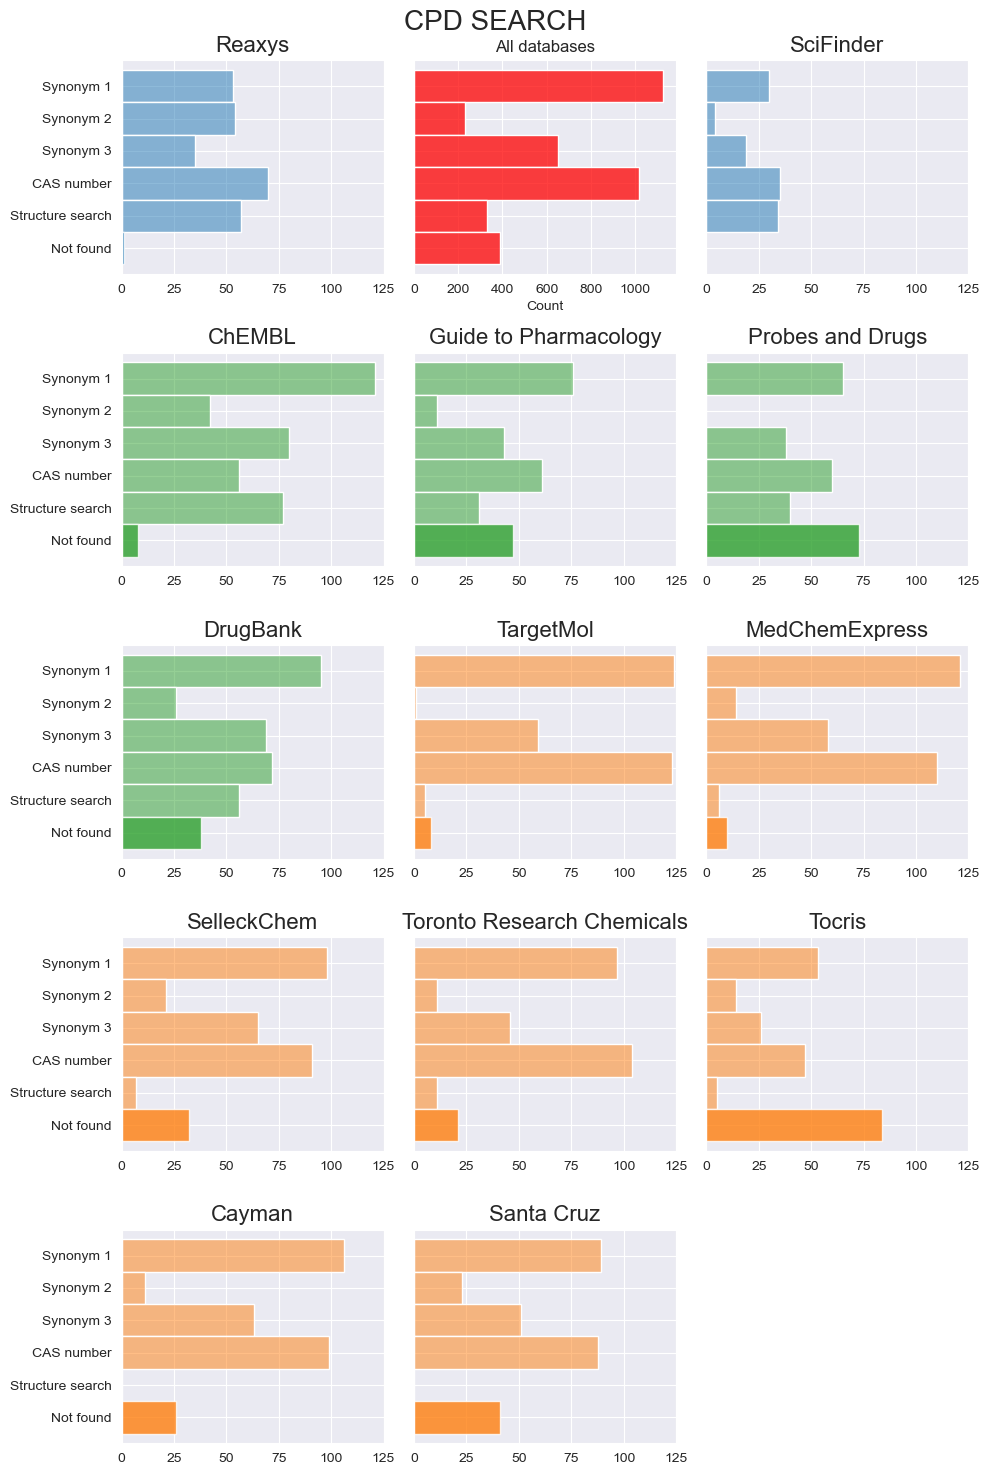

In [246]:
plot_section('CPD_search')

### Target search

Calling Script 2 to create plot for target search information

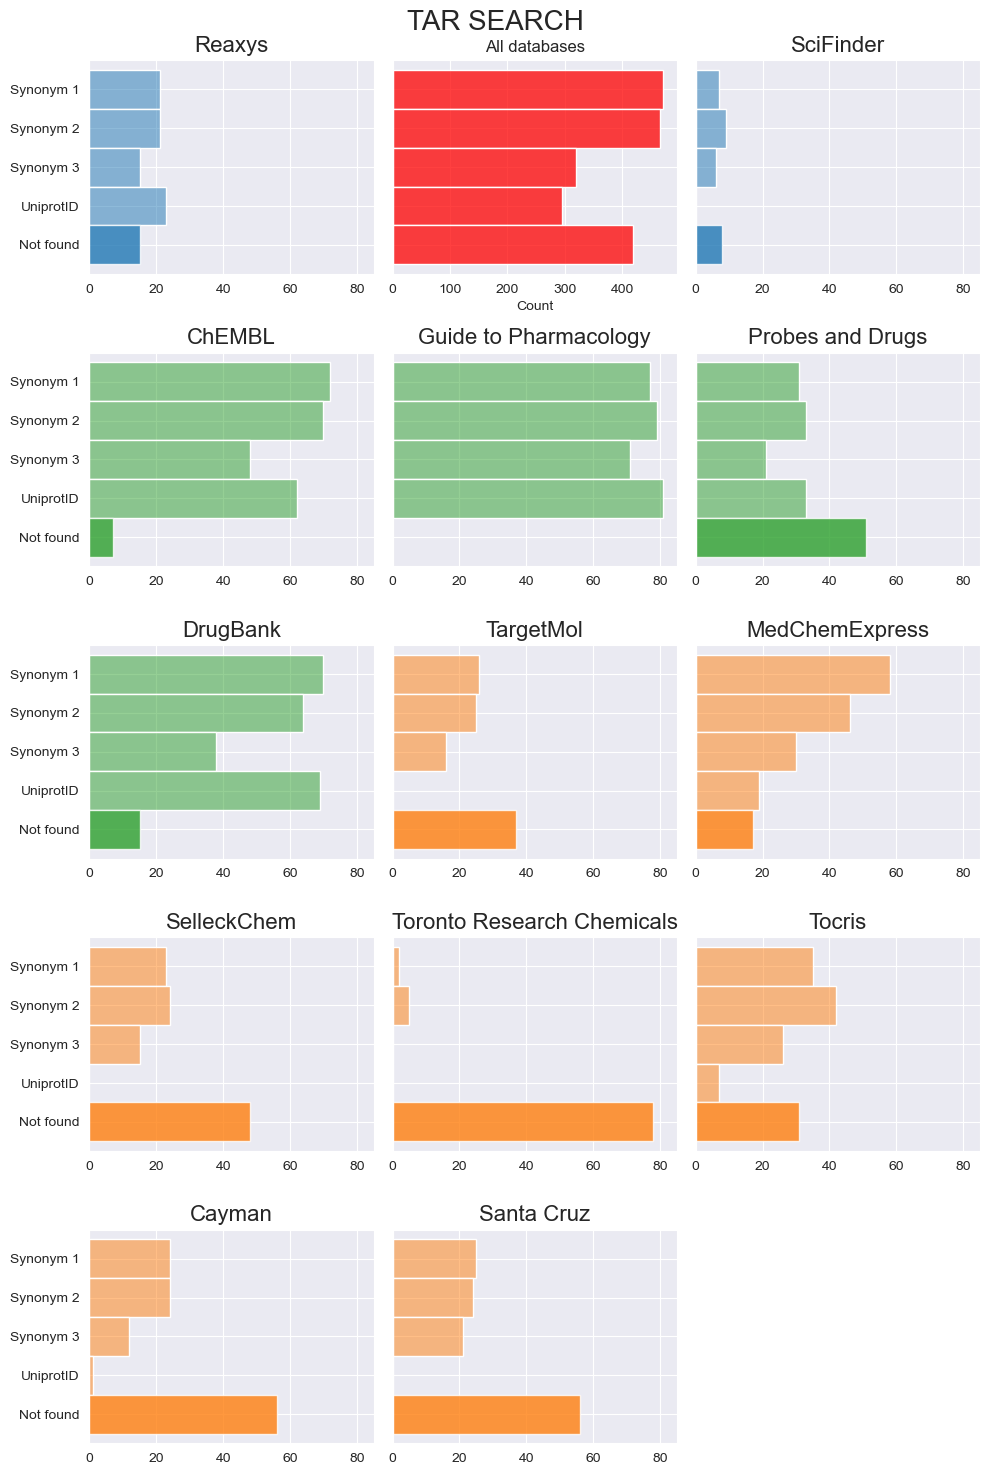

In [174]:
plot_section('TAR_search')

### Compound Biodata 

Calling Script 2 to create plot for compound biodata information

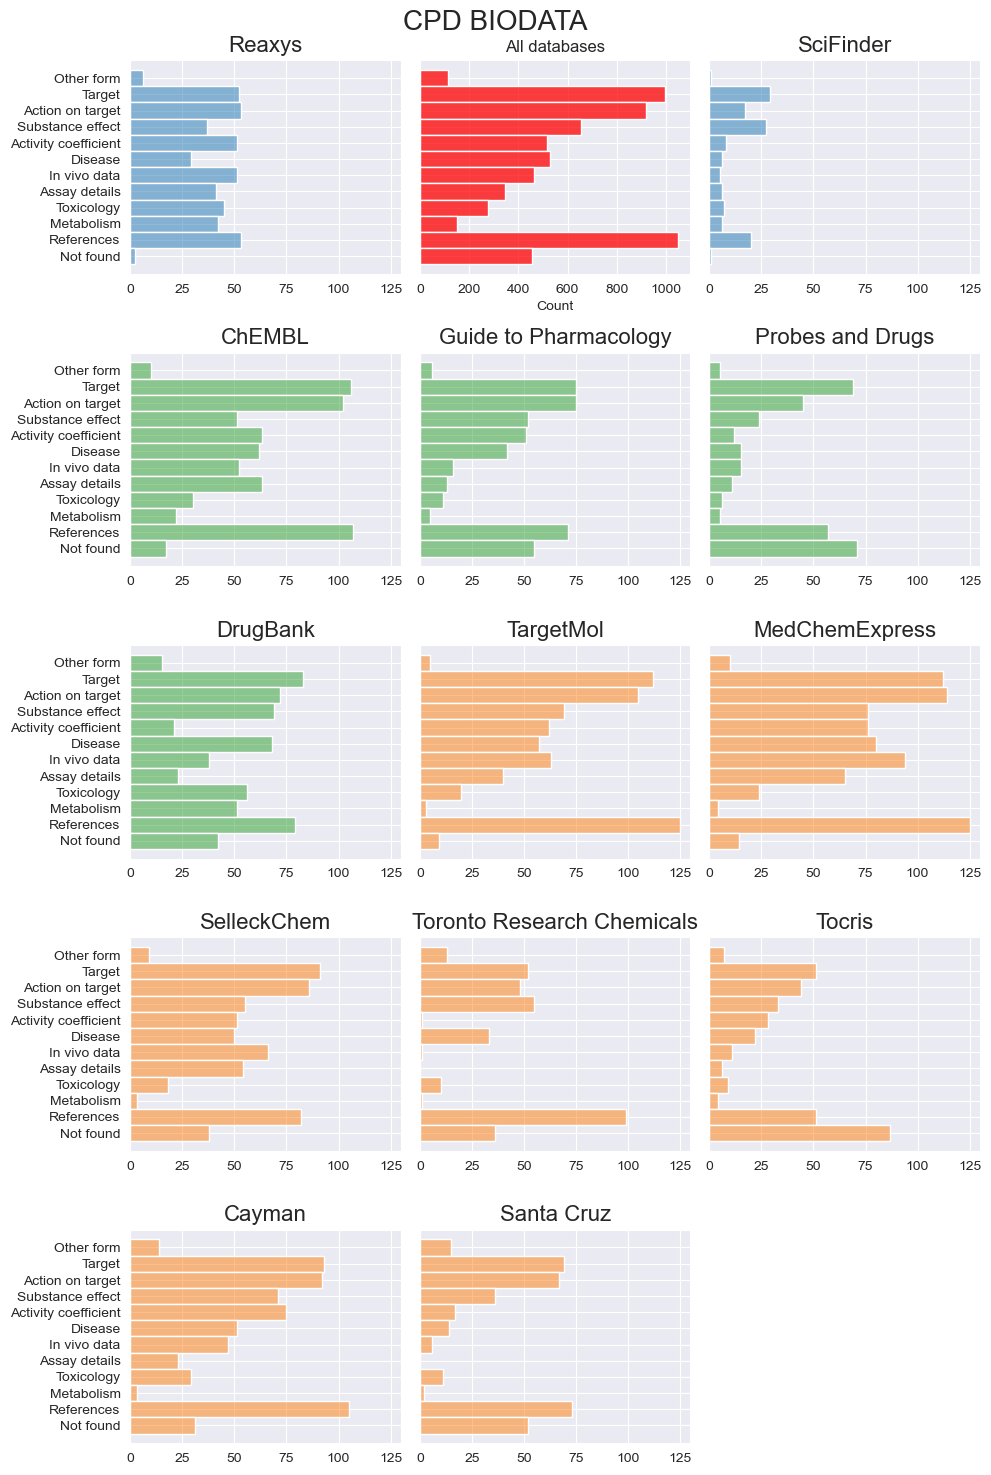

In [227]:
plot_section('CPD_biodata')

### Target Biodata 

Calling Script 2 to create plot for target biodata information

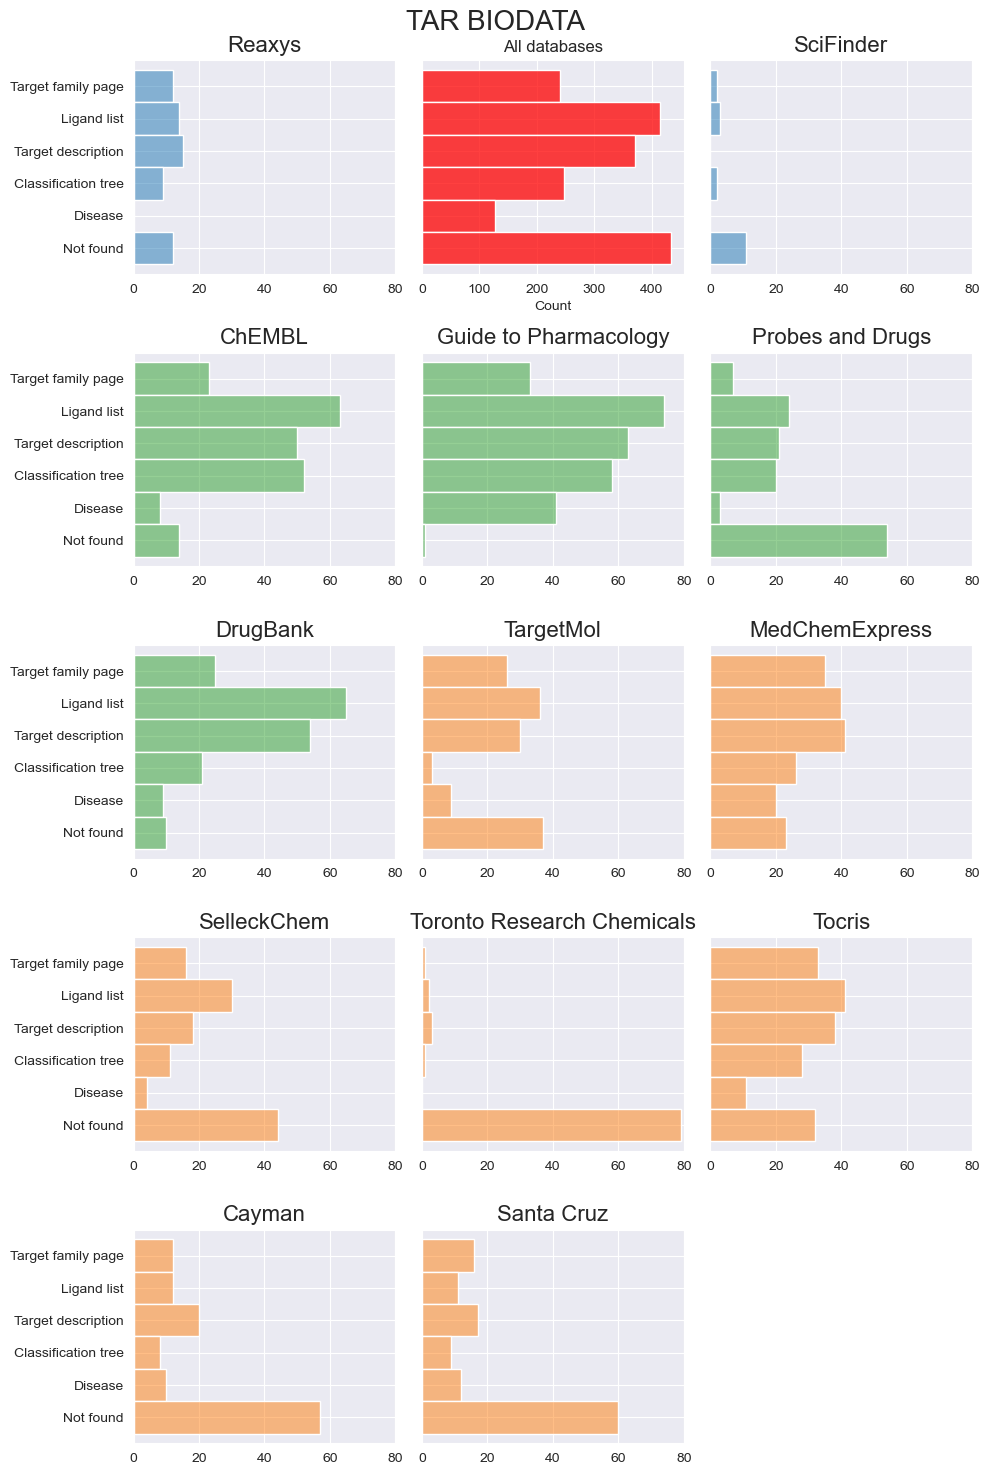

In [229]:
plot_section('TAR_biodata')

## Script 3: Creating patterns

This script creates all possible combinations of selected range of answers for each database, sorts them in descending order and returns top_n results. Also it organizes data in a convenient way for creating a plot. There is also a possibility to exclude certain parameter from analysis. 

In [233]:
from itertools import combinations
from collections import Counter

class PatternAnalysis:
    def __init__(self,grams_range, top_n, perc=0.75, remove_word=None) -> None:
        self.grams_range = grams_range
        self.top_n = top_n
        self.patterns = {}
        self.df_patterns = {}
        self.remove_word = remove_word

        cpd_biodata = ['Action on target', 'Target', 'References', 'Activity coefficient', 'Assay details', 'Disease',
        'In vivo data', 'Substance effect', 'Toxicology', 'Metabolism', 'Other form', 'Not found']
        
        tar_biodata=['Target family page','Ligand list','Target description',
                     'Classification tree','Disease','Not found']


        self.ans2can = {ans:ans.replace(' ','') for ans in cpd_biodata+tar_biodata}
        self.can2ans = {ind:ans for ans,ind in self.ans2can.items()}
        
    def _calculate(self, corpus):
        freq_dist = Counter()

        for sentence in corpus:
            words = sentence.split(' ')
            for n in range(self.grams_range[0], self.grams_range[1]+1,1):
                freq_dist.update(Counter(combinations(words,n)))

        sorted_ngrams = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
        return sorted_ngrams
    

    def _printTopResults(self,db_name, N):
        sorted_ngrams = self.patterns[db_name]
        for bigram, freq in sorted_ngrams[:N]:
            bigram = [self.can2ans[bg] for bg in bigram]
            print(" + ".join(bigram), freq)

        return self.df_patterns[db_name]
        
    def fit(self, corpus, db_name):
        if self.remove_word != None:
            corpus = [sentence.replace(' '+ self.remove_word, '') for sentence in corpus]

        sorted_ngrams = self._calculate(corpus)#[:20]
        self.patterns[db_name] = sorted_ngrams
        n=self.top_n

        self.df_patterns[db_name] = pd.DataFrame({
                            'X':[freq for _, freq in sorted_ngrams], 
                            'Y':[" + ".join([self.can2ans[bg] for bg in bigram]) for bigram, freq in sorted_ngrams]
                                })
        
    def __dataForPlot(self):
        # Data creation
        dataframes = []
        df = pd.DataFrame(self.df_patterns['All_databases'][:self.top_n])
        df['Database'] = 'All_databases'
        for db in databases:
            df = pd.DataFrame(self.df_patterns[db][:self.top_n])
            df['Database'] = db
            dataframes.append(df)
        all_info = pd.concat(dataframes, axis = 0)

        grouped_df = all_info.groupby(['Y','Database']).agg({'X':'sum'}).reset_index()

        #If not all databases in df. Add zero rows for db's
        if grouped_df.Database.unique().shape[0] != 13:
            db_left = [db for db in databases if db not in grouped_df.Database.unique()]
            df_zero = pd.DataFrame({'Y': ['None' for i in range(len(db_left))],#grouped_df.Y[0]
                                    'X': [0 for i in range(len(db_left))],
                                    'Database': db_left
                                })
            grouped_df = pd.concat([grouped_df,df_zero], axis=0)

        # Adding database type and sorting
        converter_df = pd.DataFrame(database[['database', 'database_type']].drop_duplicates(['database', 'database_type']))
        db2type = {db:db_type for i,(db, db_type) in converter_df.iterrows()}
        grouped_df['type'] = grouped_df.Database.apply(lambda db_name: db2type[db_name])
        order = {v: i for i, v in enumerate(['Closed', 'Vendor', 'Academia'])}
        result_df = grouped_df.sort_values(by='type',key=lambda x: x.map(order))
        return result_df
    
    def get_data(self):
        return self.__dataForPlot()

    def plot(self, ax):
        sns.scatterplot(data=self.__dataForPlot(), x='Database', y='Y', size='X', hue='type' ,ax=ax, 
                        palette=['C0','C1', 'C2'])
        ax.tick_params(axis='x', rotation=90)
        ax.get_legend().remove()
        ax.set(ylabel='', xlabel='')

        return[i.get_text() for i in ax.get_yticklabels()]

### Compound patterns

This code extract calls Script 3 and is used for creating plot to show popular compound patterns in each database. Also, distribution across all databases showed plotted on right. Ranges for combination was set to be from 3 to 7, top 3 results were returned and ‘References’ answer was excluded due to high frequency.   

Text(0.5, 0.98, 'COMPOUND PATTERNS')

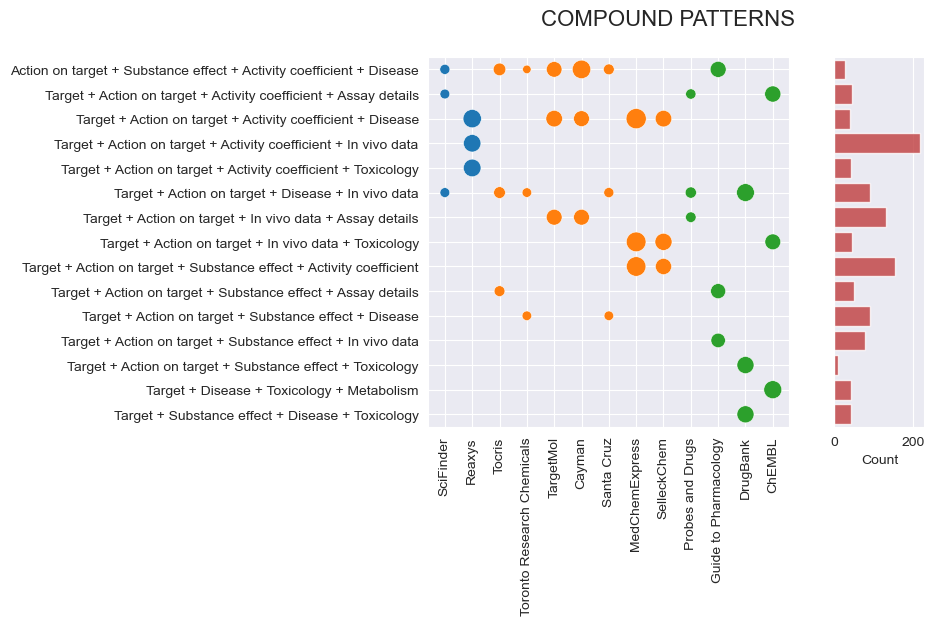

In [249]:
    
patterns_compounds = PatternAnalysis((4,7), top_n=3, remove_word='References')
allDBCorpus = []
for db_name in database.database.unique():
    DB = database[database.answer.notna() & (database.database == db_name) & (database.section == 'CPD_biodata')]
    corpus = []
    for i,idx in enumerate(DB.Id.unique()):
        processed_answers = [patterns_compounds.ans2can[item] for item in DB[DB.Id == idx].answer.to_list()]
        corpus.append(' '.join(processed_answers))

    allDBCorpus += corpus
    patterns_compounds.fit(corpus, db_name)
patterns_compounds.fit(allDBCorpus, 'All_databases')


f,ax = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [4, 1]})
lbls = patterns_compounds.plot(ax[0])
for collection in ax[0].collections:
    sizes = collection.get_sizes()
    collection.set_sizes(sizes ** 1.25)




dtx = patterns_compounds.get_data().groupby(['Y']).agg({'X':'sum'}).reset_index()
order = {v: i for i, v in enumerate(lbls)}
dtx = dtx.sort_values(by='Y',key=lambda x: x.map(order))
sns.barplot(data=dtx, y='Y', x='X', color='C3', alpha=0.8, ax=ax[1])
ax[1].set(ylabel='',
          xlabel = 'Count')
f.suptitle('COMPOUND PATTERNS', fontsize=16)

### Target Patterns

This code extract calls Script 3 and is used for creating plot to show popular target patterns in each database. Also, distribution across all databases showed plotted on right. Ranges for combination was set to be from 3 to 5, top 3 results were returned and ‘Target family page’ answer was excluded due to high frequency.   

Text(0.5, 0.98, 'TARGET PATTERNS')

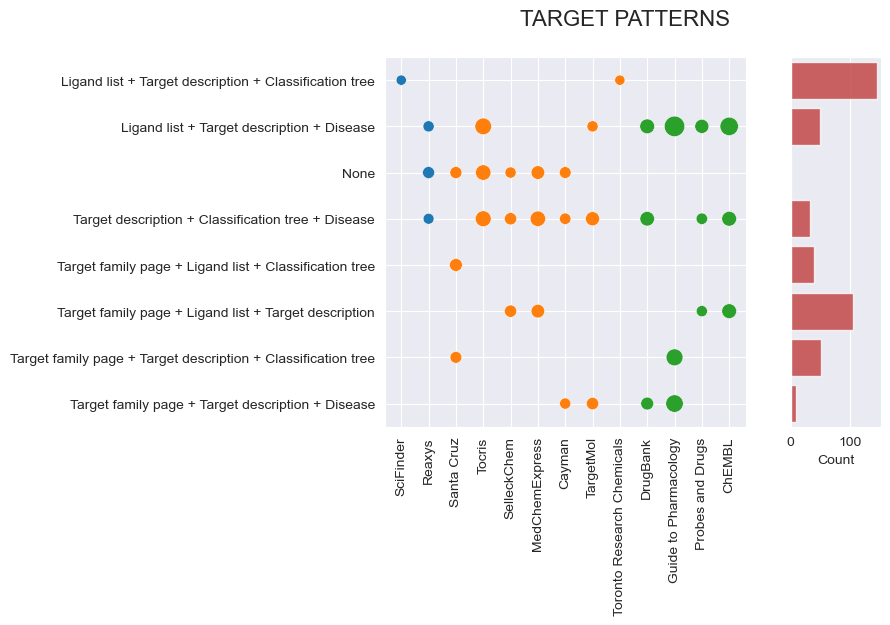

In [250]:
patterns_targets = PatternAnalysis((3,5), top_n=3, remove_word='Target family page')
allDBCorpus = []
for db_name in database.database.unique():
    DB = database[database.answer.notna() & (database.database == db_name) & (database.section == 'TAR_biodata')]
    corpus = []
    for i,idx in enumerate(DB.Id.unique()):
        processed_answers = [patterns_targets.ans2can[item] for item in DB[DB.Id == idx].answer.to_list()]
        corpus.append(' '.join(processed_answers))

    allDBCorpus += corpus
    patterns_targets.fit(corpus, db_name)
patterns_targets.fit(allDBCorpus, 'All_databases')

f,ax = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [4, 1]})
lbls = patterns_targets.plot(ax[0])
for collection in ax[0].collections:
    sizes = collection.get_sizes()
    collection.set_sizes(sizes * 3)

dtx = patterns_targets.get_data().groupby(['Y']).agg({'X':'sum'}).reset_index()
order = {v: i for i, v in enumerate(lbls)}
dtx = dtx.sort_values(by='Y',key=lambda x: x.map(order))
sns.barplot(data=dtx, y='Y', x='X', color='C3', alpha=0.8, ax=ax[1])
ax[1].set(ylabel='',
          xlabel = 'Count')
f.suptitle('TARGET PATTERNS', fontsize=16)

## Script 4: Assessment plot

This script is used to create plot for an Assessment section. Using hard code approach, it groups positive and negative characteristics (where it possible) and paints them in green (positive), red (negative) or blue (neutral). And finally, creates a figure

/var/folders/fb/3w9s6w2d3s9c5km783sbypd80000gn/T/ipykernel_26367/3782819347.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(df2, ignore_index = True)


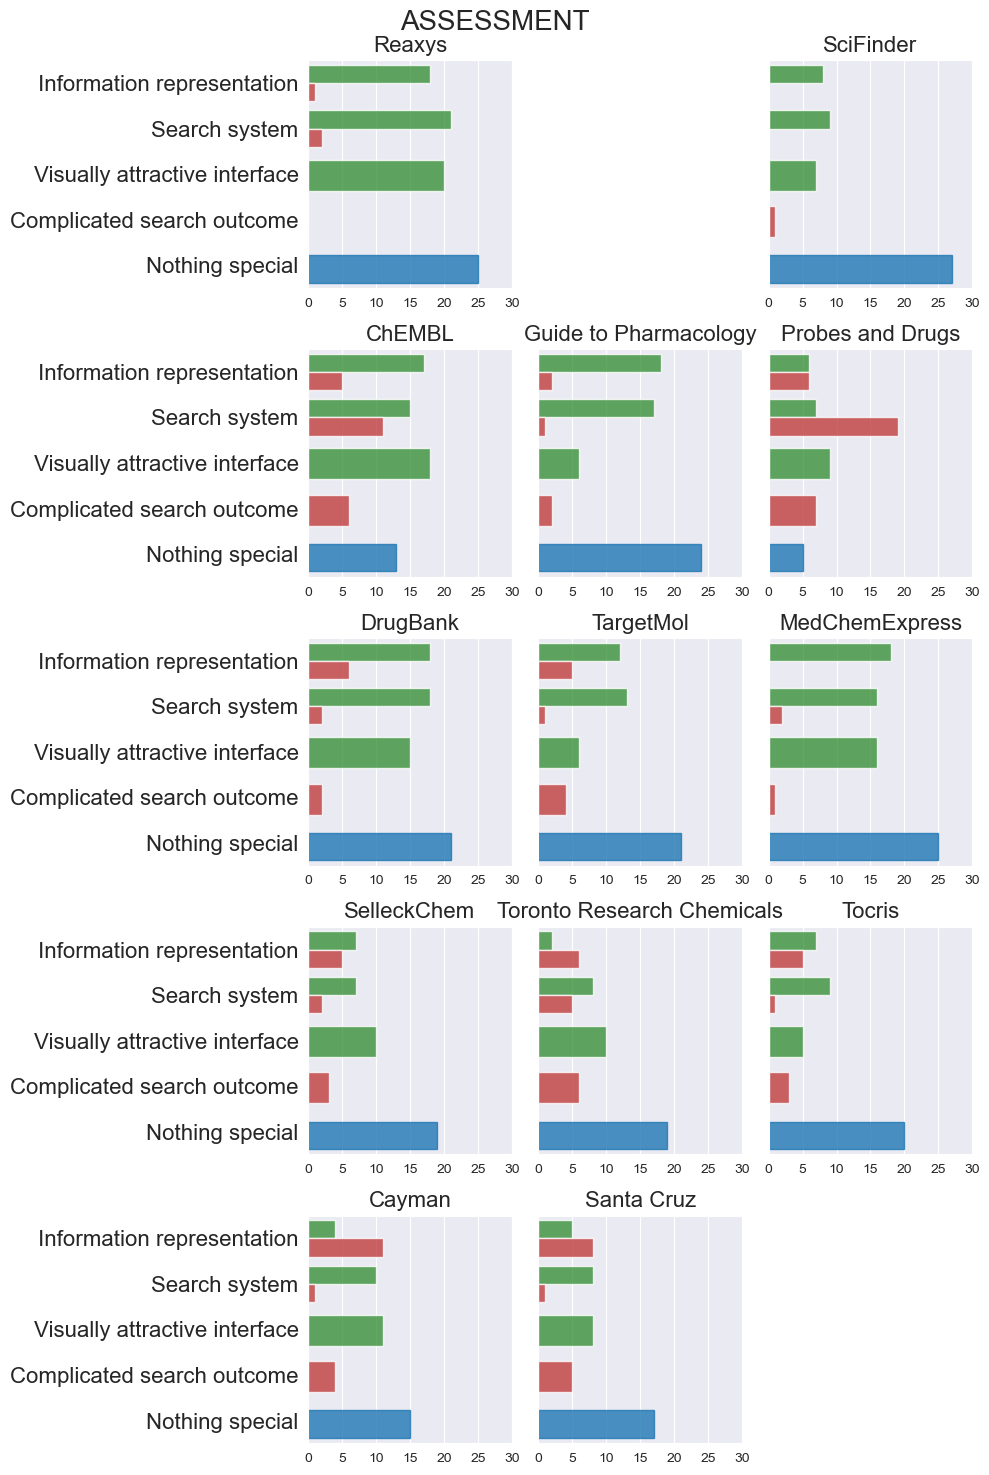

In [241]:
import numpy as np
sort_dictionary = {'Information representation':0,
                   'Search system':1,
                   'Visually attractive interface':2,
                   'Complicated search outcome':3,
                   'Nothing special':4 }
def create_data(db_name):
    df = pd.DataFrame(database[(database.section == 'Assessment') & (database.database == db_name)][['instance_category',
                                                                                                    'participant',
                                                                                                    'database',
                                                                                                    'answer',
                                                                                                    'database_type']])

    conv_asses = {'Information representation*':'Information representation', 
                'Search system**':'Search system',
                'Slow search':'Search system',
                'Nothing special':'Nothing special',
                'Visually attractive interface':'Visually attractive interface',
                'Complicated search outcome**':'Complicated search outcome',
                }
    df['test'] = [conv_asses[ans] for ans in df.answer]   
    dp = dict(df[df.instance_category == 'POSITIVE'].test.value_counts())
    dn = dict(df[df.instance_category == 'NEGATIVE'].test.value_counts())
    dfs = [pd.DataFrame({'ANS':list(dp.keys()),'count':list(dp.values()), 'Type':['Positive' for i in range(len(dp))]}),
        pd.DataFrame({'ANS':list(dn.keys()),'count':list(dn.values()), 'Type':['Negative' for i in range(len(dn))]})
    ]
    ds=pd.concat(dfs, axis=0, ignore_index=True)
    
    ix=ds[ds.ANS == 'Nothing special'].index
    ds.loc[ix,'Type'] = 'Positive'
    ds.loc[ix[0], 'count'] += ds.loc[ix[1], 'count']
    ds=ds.drop(ix[0])
    if db_name == 'Reaxys':
        df2 = {'ANS': 'Complicated search outcome', 'count': 0, 'Type': 'Positive'}
        ds = ds.append(df2, ignore_index = True)
    return ds.sort_values(by=['ANS'], axis=0, key=lambda x:x.map(sort_dictionary))

def plot(db_name,axis):
    sns.barplot(data=create_data(db_name), x='count', y='ANS',  hue='Type',
                palette=["C2", "C3",'C0'], ax=axis,  alpha=0.8)
    axis.set(ylabel="",xlabel="", title='Database: '+db_name,
             xticks=(np.arange(0, 30+1, 5)), xlim=(0,30)
                    )
    axis.get_legend().remove()
    axis.set_title(db_name, fontsize=16)
    axis.tick_params(axis='y',labelsize=16)

    for ind,p in enumerate(axis.patches):
        if ind ==4: # Noth special
            p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.5)
            p.set_y(y*1.05)

        elif ind ==8 : # Search outcome 
            #p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.7)
            p.set_y(y*0.9)
        elif ind ==2: # Attractive interface
            #p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.7)
            p.set_y(y*1.05)


#creating figure and axes
def create_AsseementPlots():

    fig, axs = plt.subplots(5,3,figsize=(10,15), sharey=True)
    axs[4,2].set_axis_off() # delete last empty axis
    fig.suptitle('ASSESSMENT', fontsize=20)
    

    #Plot central graph over ALL databases
    axs[0,1].set_axis_off() 
    #Plot side graphs over reaxys and scifinder
    plot('Reaxys', axs[0,0])
    plot('SciFinder', axs[0,2])

    #Plot graphs that left
    for i, db_name in enumerate(databases[:-2]):
        plot(db_name, axs[1+i//3 , i%3])

    fig.tight_layout()


create_AsseementPlots()